# 文心一言的市场反馈

文心一言是百度打造出来的人工智能大语言模型，用户常与ChatGPT进行对比，由此本项目通过爬取知乎热帖 [ChatGPT 和文心一言哪个更好用](https://www.zhihu.com/question/620316514/answer/3236794110) 了解用户对文心一言的使用体验和看法。通过本项目的分析，我们期待能够为文心团队提供有价值的用户反馈和改进建议，进一步优化文心一言的功能和性能，提升用户体验。

## 收集数据

In [20]:
import requests
import time
import pandas as pd
import os
import matplotlib.pyplot as plt
import jieba
import re

### 探索数据
了解接口的数据量和数据结构。注意：为了保护个人数据，此处header信息删除。

In [97]:
answer_id = '3236794110'
offset = ''
max_page = max_page 
page = 1
all_raw_comments = []  # 存储所有评论的列表
url = 'https://www.zhihu.com/api/v4/answers/{}/root_comments?order=normal&limit=20&offset={}&status=open'.format(answer_id, offset)

In [9]:
r0 = requests.get(url, headers=headers)
total = r0.json()['counts']['total_counts']  # 一共多少条评论
print('一共{}条评论'.format(total))

一共421条评论


In [96]:
# 判断一共多少页（每页20条评论）
max_page = int(total / 20)
print('max_page:', max_page)

max_page: 21


### 解析数据
该回答下的评论有21页，所以需要用循环获取每页的数据。

In [98]:
while page <= max_page:
    offset = (page - 1) * 20 if page > 1 else ''  # 如果是第一页，则偏移量为空，否则按照公式计算    
    time.sleep(5) 
    r = requests.get(url, headers=headers)
    i=0
    print('正在爬取第{}页'.format(page))
    if r.status_code == 200:
        j_data = r.json()
        comments = j_data['data']
        
        all_raw_comments.extend(comments)  # 将当前页面的评论追加到存储所有评论的列表中
        
        page += 1  # 将页数加1，继续下一页的循环
        
    else:
        print('请求失败，状态码：', r.status_code)

正在爬取第1页
正在爬取第2页
正在爬取第3页
正在爬取第4页
正在爬取第5页
正在爬取第6页
正在爬取第7页
正在爬取第8页
正在爬取第9页
正在爬取第10页
正在爬取第11页
正在爬取第12页
正在爬取第13页
正在爬取第14页
正在爬取第15页
正在爬取第16页
正在爬取第17页
正在爬取第18页
正在爬取第19页
正在爬取第20页
正在爬取第21页


In [49]:
all_comments[2]

{'id': 10696042513,
 'type': 'comment',
 'url': 'https://www.zhihu.com/api/v4/comments/10696042513',
 'content': '很详细[赞同][赞同][赞同]',
 'featured': False,
 'top': False,
 'collapsed': False,
 'is_author': False,
 'is_delete': False,
 'created_time': 1696441467,
 'resource_type': 'answer',
 'reviewing': False,
 'allow_like': True,
 'allow_delete': False,
 'allow_reply': True,
 'allow_vote': True,
 'can_recommend': False,
 'can_collapse': False,
 'attached_info': 'ggIGCAsQARgC',
 'author': {'role': 'normal',
  'member': {'id': '67abaaa5b3729df0c4b940b68514330d',
   'url_token': 'dym-3-25',
   'name': '木兮小天地',
   'avatar_url': 'https://picx.zhimg.com/v2-02c86d89cb091ff9cb6febc83e1f232f.jpg?source=06d4cd63',
   'avatar_url_template': 'https://picx.zhimg.com/v2-02c86d89cb091ff9cb6febc83e1f232f.jpg?source=06d4cd63',
   'is_org': False,
   'type': 'people',
   'url': 'https://www.zhihu.com/api/v4/people/67abaaa5b3729df0c4b940b68514330d',
   'user_type': 'people',
   'headline': '生活美学 | 家居艺术｜数码家电

'child_comment_count'的值说明有的评论下还有二级评论，所以我决定用parent_id来表明层级关系，对每条评论抓取 id, ip, 内容(content), 创建时间(created_time)，子评论量(child_comment_count)。

In [ ]:
# 创建一个空列表，用于存储所有评论对象
all_comments = []

# 遍历所有评论数据
loop_count = 0
for comment_data in all_raw_comments:
    # 提取评论信息
    comment_id = comment_data['id']
    comment_content = comment_data['content']
    comment_ip = comment_data['address_text'].split('属地')[-1].strip()
    comment_gender = comment_data['author']['member']['gender']
    comment_date = comment_data['created_time']
    child_comment_count = comment_data['child_comment_count']
    parent_id = comment_id
    
    loop_count += 1
    print(loop_count)
    # 判断是否有子评论
    if child_comment_count != 0:
        # 存储一级评论
        top_level_comment = {
            'id': comment_id ,
            'content': comment_content,
            'date': comment_date,
            'ip': comment_ip,
            'gender': comment_gender,
            'child_comment_count': child_comment_count,
            'parent_id': None  # 一级评论的 parent_id 为空
        }
        all_comments.append(top_level_comment)
        
        # 提取二级评论
        child_url = 'https://www.zhihu.com/api/v4/comment_v5/comment/{}/child_comment?order_by=ts&limit=20&offset={}'.format(parent_id, offset)
        while True:
            time.sleep(5) 
            child_r = requests.get(child_url, headers=headers)
            child_j_data = child_r.json()
            
            for child_comment in child_j_data['data']:
                second_level_comment = {
                    'id': child_comment['id'],
                    'content': child_comment['content'],
                    'date': child_comment['created_time'],
                    'ip': child_comment['comment_tag'][0]['text'].split('属地')[-1].strip(),
                    'gender': child_comment['author']['gender'],
                    'child_comment_count': 0,  # 二级评论没有子评论
                    'parent_id': parent_id   # 二级评论的 parent_id 为一级评论的 id
                }
                all_comments.append(second_level_comment)
  
            paging = child_j_data['paging']
            if paging['is_end']:
                break
            else:
                child_url = paging['next']
                # print(child_url)

            all_comments.append(second_level_comment)
    else:
        # 存储一级评论
        top_level_comment = {
            'id': comment_id,
            'content': comment_content,
            'date': comment_date,
            'ip': comment_ip,
            'gender': comment_gender,
            'child_comment_count': 0,  # 一级评论没有子评论
            'parent_id': None  # 一级评论的 parent_id 为空
        }
        all_comments.append(top_level_comment)

print('好咯')

In [101]:
len(all_comments)

424

从该回答中总共获得了424条评论，将数据存储为dataframe 方便用pandas库进行操控。

In [104]:
df = pd.DataFrame(all_comments)
df 

,id,content,date,ip,gender,child_comment_count,parent_id
0,10695921940,我的建议是有条件就一步到位直接上gpt4，其他的都不用考虑，退而求其次就是new bing ...,1696431540,浙江,1,40,NaN
1,10696038327,Gpt4好，就是要钱太贵[捂脸],1696431744,福建,2,0,1.069592e+10
2,10695691786,找几个朋友一起拼车，分担一下费用会好很多,1696432130,浙江,2,0,1.069592e+10
3,10698881848,4要钱，而且要魔法，随时可能账号被封,1696775450,福建,0,0,1.069592e+10
4,10698899555,要钱不是很正常吗，完全物超所值的呀，不要一堆人瞎用根本不会被封号，我和朋友共用了几个月都没遇...,1696775665,浙江,2,0,1.069592e+10
...,...,...,...,...,...,...,...
419,10755016037,别尬吹了 你让文心一言画个炒饼就知道谁厉害了 [doge],1702960511,北京,-1,0,NaN
420,10749932644,<p>图贴的多就有道理麽？文心一言都说好用，那真是大便当巧克力吃~~~~</p>,1702364083,上海,1,3,NaN
421,10750196814,提示词不会用，用什么大模型都出不了效果，我日常就是用文心一言,1702364210,福建,2,0,1.074993e+10
422,10753947364,看我主页对文心4.0的数学测试,1702775250,河南,2,0,1.074993e+10


In [114]:
#将当前数据保存
df.to_csv('df_0422.csv')

### 清理数据
1. 处理parent_id列：确保parent_id列中的值不使用科学计数法，并将其转换为字符串形式，以便在数据集中保持一致性。
2.   处理(gender)性别列：将性别列中的未知参数（例0和-1，2）转换为可识别的标签（例如，"Unknown"），以便更好地理解和分析数
3. 日期(date)处理时间列：将时间时间戳十位数字转换为可读的日期时间格式，以便更容易理解和分析时间相关的数据。

In [128]:
df = pd.read_csv('df_0422.csv')
df = df.drop(df.columns[0], axis=1)
# 讲科学计数转为字符串
df['parent_id'] = df['parent_id'].apply(lambda x: '{:.0f}'.format(x) if pd.notnull(x) else x)
df

,id,content,date,ip,gender,child_comment_count,parent_id
0,10695921940,我的建议是有条件就一步到位直接上gpt4，其他的都不用考虑，退而求其次就是new bing ...,1696431540,浙江,1,40,NaN
1,10696038327,Gpt4好，就是要钱太贵[捂脸],1696431744,福建,2,0,10695921940
2,10695691786,找几个朋友一起拼车，分担一下费用会好很多,1696432130,浙江,2,0,10695921940
3,10698881848,4要钱，而且要魔法，随时可能账号被封,1696775450,福建,0,0,10695921940
4,10698899555,要钱不是很正常吗，完全物超所值的呀，不要一堆人瞎用根本不会被封号，我和朋友共用了几个月都没遇...,1696775665,浙江,2,0,10695921940
...,...,...,...,...,...,...,...
419,10755016037,别尬吹了 你让文心一言画个炒饼就知道谁厉害了 [doge],1702960511,北京,-1,0,NaN
420,10749932644,<p>图贴的多就有道理麽？文心一言都说好用，那真是大便当巧克力吃~~~~</p>,1702364083,上海,1,3,NaN
421,10750196814,提示词不会用，用什么大模型都出不了效果，我日常就是用文心一言,1702364210,福建,2,0,10749932644
422,10753947364,看我主页对文心4.0的数学测试,1702775250,河南,2,0,10749932644


In [129]:
def trans_date(v_timestamp):
	#10位时间戳转换为时间字符串
	timeArray = time.localtime(v_timestamp)
	otherStyleTime = time.strftime("%Y-%m-%d %H:%M:%S", timeArray)
	return otherStyleTime

df['date'] = df['date'].apply(trans_date)
df

,id,content,date,ip,gender,child_comment_count,parent_id
0,10695921940,我的建议是有条件就一步到位直接上gpt4，其他的都不用考虑，退而求其次就是new bing ...,2023-10-04 16:59:00,浙江,1,40,NaN
1,10696038327,Gpt4好，就是要钱太贵[捂脸],2023-10-04 17:02:24,福建,2,0,10695921940
2,10695691786,找几个朋友一起拼车，分担一下费用会好很多,2023-10-04 17:08:50,浙江,2,0,10695921940
3,10698881848,4要钱，而且要魔法，随时可能账号被封,2023-10-08 16:30:50,福建,0,0,10695921940
4,10698899555,要钱不是很正常吗，完全物超所值的呀，不要一堆人瞎用根本不会被封号，我和朋友共用了几个月都没遇...,2023-10-08 16:34:25,浙江,2,0,10695921940
...,...,...,...,...,...,...,...
419,10755016037,别尬吹了 你让文心一言画个炒饼就知道谁厉害了 [doge],2023-12-19 05:35:11,北京,-1,0,NaN
420,10749932644,<p>图贴的多就有道理麽？文心一言都说好用，那真是大便当巧克力吃~~~~</p>,2023-12-12 07:54:43,上海,1,3,NaN
421,10750196814,提示词不会用，用什么大模型都出不了效果，我日常就是用文心一言,2023-12-12 07:56:50,福建,2,0,10749932644
422,10753947364,看我主页对文心4.0的数学测试,2023-12-17 02:07:30,河南,2,0,10749932644


In [133]:
# 将性别转化为字符串
# 将数值转化为文本
gender_mapping = {2: 'Male', 1: 'Female'}
df['gender'] = df['gender'].map(gender_mapping).fillna('Unknown')
df

,id,content,date,ip,gender,child_comment_count,parent_id
0,10695921940,我的建议是有条件就一步到位直接上gpt4，其他的都不用考虑，退而求其次就是new bing ...,2023-10-04 16:59:00,浙江,Female,40,NaN
1,10696038327,Gpt4好，就是要钱太贵[捂脸],2023-10-04 17:02:24,福建,Male,0,10695921940
2,10695691786,找几个朋友一起拼车，分担一下费用会好很多,2023-10-04 17:08:50,浙江,Male,0,10695921940
3,10698881848,4要钱，而且要魔法，随时可能账号被封,2023-10-08 16:30:50,福建,Unknown,0,10695921940
4,10698899555,要钱不是很正常吗，完全物超所值的呀，不要一堆人瞎用根本不会被封号，我和朋友共用了几个月都没遇...,2023-10-08 16:34:25,浙江,Male,0,10695921940
...,...,...,...,...,...,...,...
419,10755016037,别尬吹了 你让文心一言画个炒饼就知道谁厉害了 [doge],2023-12-19 05:35:11,北京,Unknown,0,NaN
420,10749932644,<p>图贴的多就有道理麽？文心一言都说好用，那真是大便当巧克力吃~~~~</p>,2023-12-12 07:54:43,上海,Female,3,NaN
421,10750196814,提示词不会用，用什么大模型都出不了效果，我日常就是用文心一言,2023-12-12 07:56:50,福建,Male,0,10749932644
422,10753947364,看我主页对文心4.0的数学测试,2023-12-17 02:07:30,河南,Male,0,10749932644


In [136]:
df.to_csv('df_clean_0422.csv')

## 数据分析

In [108]:
df = pd.read_csv('df_clean_0422.csv')
df = df.drop(df.columns[0], axis=1)
df

,id,content,date,ip,gender,child_comment_count,parent_id
0,10695921940,我的建议是有条件就一步到位直接上gpt4，其他的都不用考虑，退而求其次就是new bing ...,2023-10-04 16:59:00,浙江,Female,40,NaN
1,10696038327,Gpt4好，就是要钱太贵[捂脸],2023-10-04 17:02:24,福建,Male,0,1.069592e+10
2,10695691786,找几个朋友一起拼车，分担一下费用会好很多,2023-10-04 17:08:50,浙江,Male,0,1.069592e+10
3,10698881848,4要钱，而且要魔法，随时可能账号被封,2023-10-08 16:30:50,福建,Unknown,0,1.069592e+10
4,10698899555,要钱不是很正常吗，完全物超所值的呀，不要一堆人瞎用根本不会被封号，我和朋友共用了几个月都没遇...,2023-10-08 16:34:25,浙江,Male,0,1.069592e+10
...,...,...,...,...,...,...,...
419,10755016037,别尬吹了 你让文心一言画个炒饼就知道谁厉害了 [doge],2023-12-19 05:35:11,北京,Unknown,0,NaN
420,10749932644,<p>图贴的多就有道理麽？文心一言都说好用，那真是大便当巧克力吃~~~~</p>,2023-12-12 07:54:43,上海,Female,3,NaN
421,10750196814,提示词不会用，用什么大模型都出不了效果，我日常就是用文心一言,2023-12-12 07:56:50,福建,Male,0,1.074993e+10
422,10753947364,看我主页对文心4.0的数学测试,2023-12-17 02:07:30,河南,Male,0,1.074993e+10


### 数据清理
中文数据清理一般包括去除特殊字符，数字，标点符号，HTML标签，停用词。本项目中数字可能代表产品版本，而英文则可能是指代软件工具，所以清理重点在HTML标签和特殊字符，标点符号以及停用词。

In [109]:
# 计算包含缺失值的行数
missing_count = df["content"].isna().sum()
# 显示结果
print("缺失值的数量:", missing_count)

缺失值的数量: 0


In [105]:
def load_stopwords(file_path):
    with open(file_path, 'r', encoding='gbk') as file:
        stopwords = [line.strip() for line in file]
    return stopwords

def clean_text(text, stopwords):
    # 去除HTML标签
    cleaned_text = re.sub(r'<[^>]+>', ' ', text)
    # 去除特殊字符和标点符号
    cleaned_text = re.sub(r'[^\u4e00-\u9fa5a-zA-Z0-9\s]', ' ', cleaned_text)
    # 去除多余的空白字符
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text)
    # 去除停用词
    cleaned_text = ' '.join(word for word in jieba.lcut(cleaned_text) if word not in stopwords)
    return cleaned_text.strip()  # 去除文本两端的空格

# 读取停用词文件
stopwords_file = "wenxinyiyan/百度停用词列表.txt"
stopwords = load_stopwords(stopwords_file)

In [110]:
# 将function应用到content列上
df["clean_content"] = df["content"].apply(lambda x: clean_text(x, stopwords))
# 删掉原来的content列
df.drop(columns=["content"], inplace=True)
df

,id,date,ip,gender,child_comment_count,parent_id,clean_content
0,10695921940,2023-10-04 16:59:00,浙江,Female,40,NaN,建议 条件 一步到位 上 gpt4 都 不用 退而求其次 bing clau...
1,10696038327,2023-10-04 17:02:24,福建,Male,0,1.069592e+10,Gpt4 好 要钱 太贵 捂脸
2,10695691786,2023-10-04 17:08:50,浙江,Male,0,1.069592e+10,找 几个 朋友 拼车 分担 费用 会 好 很多
3,10698881848,2023-10-08 16:30:50,福建,Unknown,0,1.069592e+10,4 要钱 魔法 随时 账号 封
4,10698899555,2023-10-08 16:34:25,浙江,Male,0,1.069592e+10,要钱 很 物超所值 一堆 人瞎用 封号 朋友 共用 几个 月 都 没
...,...,...,...,...,...,...,...
419,10755016037,2023-12-19 05:35:11,北京,Unknown,0,NaN,别尬 吹 文心 一言画 炒 饼 厉害 doge
420,10749932644,2023-12-12 07:54:43,上海,Female,3,NaN,图贴 道理 麽 文心 一言 都 说好 大 便当 巧克力 吃
421,10750196814,2023-12-12 07:56:50,福建,Male,0,1.074993e+10,提示 词 大 模型 都 出 不了 效果 日常 文心 言
422,10753947364,2023-12-17 02:07:30,河南,Male,0,1.074993e+10,看 主页 文心 4 0 数学 测试


文本中的英文也处理为小写

In [111]:
# 将英文文本转换为小写，同时保持中文文本不变
def convert_english_to_lowercase(text):
    # 正则表达式匹配英文单词
    pattern = re.compile(r'[a-zA-Z]+')
    # 使用 re.sub() 函数和 lambda 函数将小写转换应用于英文单词
    return pattern.sub(lambda x: x.group(0).lower(), text)
# 应用于 "clean_content" 列
df["text"] = df["clean_content"].apply(convert_english_to_lowercase)
# 删除原始的 "clean_content" 列
df.drop(columns=["clean_content"], inplace=True)
df

,id,date,ip,gender,child_comment_count,parent_id,text
0,10695921940,2023-10-04 16:59:00,浙江,Female,40,NaN,建议 条件 一步到位 上 gpt4 都 不用 退而求其次 bing clau...
1,10696038327,2023-10-04 17:02:24,福建,Male,0,1.069592e+10,gpt4 好 要钱 太贵 捂脸
2,10695691786,2023-10-04 17:08:50,浙江,Male,0,1.069592e+10,找 几个 朋友 拼车 分担 费用 会 好 很多
3,10698881848,2023-10-08 16:30:50,福建,Unknown,0,1.069592e+10,4 要钱 魔法 随时 账号 封
4,10698899555,2023-10-08 16:34:25,浙江,Male,0,1.069592e+10,要钱 很 物超所值 一堆 人瞎用 封号 朋友 共用 几个 月 都 没
...,...,...,...,...,...,...,...
419,10755016037,2023-12-19 05:35:11,北京,Unknown,0,NaN,别尬 吹 文心 一言画 炒 饼 厉害 doge
420,10749932644,2023-12-12 07:54:43,上海,Female,3,NaN,图贴 道理 麽 文心 一言 都 说好 大 便当 巧克力 吃
421,10750196814,2023-12-12 07:56:50,福建,Male,0,1.074993e+10,提示 词 大 模型 都 出 不了 效果 日常 文心 言
422,10753947364,2023-12-17 02:07:30,河南,Male,0,1.074993e+10,看 主页 文心 4 0 数学 测试


In [112]:
df.to_csv('df_clean_stopwords_0424.csv')

### 情感分析

In [113]:
df = pd.read_csv('df_clean_stopwords_0424.csv')

In [116]:
df

,Unnamed: 0,id,date,ip,gender,child_comment_count,parent_id,text
0,0,10695921940,2023-10-04 16:59:00,浙江,Female,40,NaN,建议 条件 一步到位 上 gpt4 都 不用 退而求其次 bing clau...
1,1,10696038327,2023-10-04 17:02:24,福建,Male,0,1.069592e+10,gpt4 好 要钱 太贵 捂脸
2,2,10695691786,2023-10-04 17:08:50,浙江,Male,0,1.069592e+10,找 几个 朋友 拼车 分担 费用 会 好 很多
3,3,10698881848,2023-10-08 16:30:50,福建,Unknown,0,1.069592e+10,4 要钱 魔法 随时 账号 封
4,4,10698899555,2023-10-08 16:34:25,浙江,Male,0,1.069592e+10,要钱 很 物超所值 一堆 人瞎用 封号 朋友 共用 几个 月 都 没
...,...,...,...,...,...,...,...,...
419,419,10755016037,2023-12-19 05:35:11,北京,Unknown,0,NaN,别尬 吹 文心 一言画 炒 饼 厉害 doge
420,420,10749932644,2023-12-12 07:54:43,上海,Female,3,NaN,图贴 道理 麽 文心 一言 都 说好 大 便当 巧克力 吃
421,421,10750196814,2023-12-12 07:56:50,福建,Male,0,1.074993e+10,提示 词 大 模型 都 出 不了 效果 日常 文心 言
422,422,10753947364,2023-12-17 02:07:30,河南,Male,0,1.074993e+10,看 主页 文心 4 0 数学 测试


#### Snownlp

In [114]:
from snownlp import SnowNLP

In [117]:
def sentiment(text):
    return SnowNLP(text).sentiments
# 使用 apply() 方法应用情感分析函数，但只对文本长度大于0的行进行处理
df['text'] = df['text'].astype(str)
df['sentiment'] = df[df['text'].apply(lambda x: len(x) > 0)]['text'].apply(sentiment)
df

,Unnamed: 0,id,date,ip,gender,child_comment_count,parent_id,text,sentiment
0,0,10695921940,2023-10-04 16:59:00,浙江,Female,40,NaN,建议 条件 一步到位 上 gpt4 都 不用 退而求其次 bing clau...,0.007502
1,1,10696038327,2023-10-04 17:02:24,福建,Male,0,1.069592e+10,gpt4 好 要钱 太贵 捂脸,0.011116
2,2,10695691786,2023-10-04 17:08:50,浙江,Male,0,1.069592e+10,找 几个 朋友 拼车 分担 费用 会 好 很多,0.642283
3,3,10698881848,2023-10-08 16:30:50,福建,Unknown,0,1.069592e+10,4 要钱 魔法 随时 账号 封,0.842227
4,4,10698899555,2023-10-08 16:34:25,浙江,Male,0,1.069592e+10,要钱 很 物超所值 一堆 人瞎用 封号 朋友 共用 几个 月 都 没,0.730268
...,...,...,...,...,...,...,...,...,...
419,419,10755016037,2023-12-19 05:35:11,北京,Unknown,0,NaN,别尬 吹 文心 一言画 炒 饼 厉害 doge,0.258900
420,420,10749932644,2023-12-12 07:54:43,上海,Female,3,NaN,图贴 道理 麽 文心 一言 都 说好 大 便当 巧克力 吃,0.880308
421,421,10750196814,2023-12-12 07:56:50,福建,Male,0,1.074993e+10,提示 词 大 模型 都 出 不了 效果 日常 文心 言,0.985755
422,422,10753947364,2023-12-17 02:07:30,河南,Male,0,1.074993e+10,看 主页 文心 4 0 数学 测试,0.236901


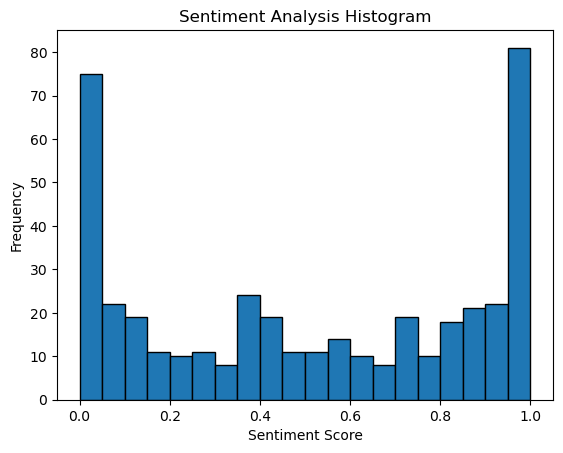

In [118]:
# 创建直方图
plt.hist(df['sentiment'], bins=20, edgecolor='black')

# 添加标题和标签
plt.title('Sentiment Analysis Histogram')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')

# 显示图形
plt.show()


In [119]:
# 按照 sentiment 列进行降序排序，并选择前5条文本
top_5_texts = df.sort_values(by='sentiment', ascending=False).head(5)['text']

# 打印结果
print(top_5_texts)

119    很少 ai 搜 这类   不   古诗 带 意境   ai 现时 都 不好 使   看 文心...
227    希望 一日 一款 视频 回答 ai 软件   实时 生成 视频 回答   希望 一日 大 数...
254    没   一篇 符合 诗歌   月 圆之夜   中秋佳节   家人 团聚   欢声笑语   月...
258    只不过 希望 单恋   消失 快得象 四月 里   一句 话   一个 眼色 却 教 胡思乱...
376    文心 言   编 100 三个 字 名字   张小红   王小刚   刘小云   陈小华  ...
Name: text, dtype: object


In [120]:
# 按照 sentiment 列进行升序排序，并选择前5条文本
last_5_texts = df.sort_values(by='sentiment', ascending=True).head(5)['text']

# 打印结果
print(last_5_texts)

378    问 文心 一言 3   5   3 杯 25   c 水 混合 多少度   答   3 杯 ...
77     4 杯 25   水   混合     混合 后 水 温度     理解 温度 加权 平均 ...
86     4 杯 温度 25   c 水 混合   最终 温度 取决于 杯水 体积 大小   假设 杯...
71     才 试 下   4 杯 25   水   混合     混合 后 水 温度     理解 温...
229    11 月 更新 后 gpt3   5 会 藏拙   敷衍   吃瓜   说 点 好话 发挥 ...
Name: text, dtype: object


当查看具体的评论时，可以发现snowNLP的结果并不理想，snowNLP的语料库主要是电商评论数据，所以采取基于词典的方法。

#### 基于Boson情感词典

In [124]:
# 加载玻森情感词典
df_sentiment_score = pd.read_table("wenxinyiyan/BosonNLP_sentiment_score.txt",sep= " ",names=['key','score'])
df_sentiment_score

,key,score
0,最尼玛,-6.704000
1,扰民,-6.497564
2,fuck...,-6.329634
3,RNM,-6.218613
4,wcnmlgb,-5.967100
...,...,...
114761,prada667,6.375039
114762,如虎添翼,6.375039
114763,定购,6.375039
114764,富婆团,6.375039


In [125]:
# 计算tokenized_text的sentiment score
key = df_sentiment_score['key'].values.tolist()
score = df_sentiment_score['score'].values.tolist()

def getscore(text):
    text_score = 0
    # 使用jieba进行分词
    text = str(text)
    words = [word.strip() for word in jieba.lcut(text) if word.strip()]
    for tokenized_text in words:
        if tokenized_text in key:
            text_score += score[key.index(tokenized_text)]
    return text_score

In [126]:
df = pd.read_csv('df_clean_stopwords_0424.csv')

# 对 df 中的 tokenized_text 计算情感得分
df['sentiment_score'] = df['text'].apply(getscore)
df

,Unnamed: 0,id,date,ip,gender,child_comment_count,parent_id,text,sentiment_score
0,0,10695921940,2023-10-04 16:59:00,浙江,Female,40,NaN,建议 条件 一步到位 上 gpt4 都 不用 退而求其次 bing clau...,5.426568
1,1,10696038327,2023-10-04 17:02:24,福建,Male,0,1.069592e+10,gpt4 好 要钱 太贵 捂脸,1.226295
2,2,10695691786,2023-10-04 17:08:50,浙江,Male,0,1.069592e+10,找 几个 朋友 拼车 分担 费用 会 好 很多,2.748294
3,3,10698881848,2023-10-08 16:30:50,福建,Unknown,0,1.069592e+10,4 要钱 魔法 随时 账号 封,6.295669
4,4,10698899555,2023-10-08 16:34:25,浙江,Male,0,1.069592e+10,要钱 很 物超所值 一堆 人瞎用 封号 朋友 共用 几个 月 都 没,0.248269
...,...,...,...,...,...,...,...,...,...
419,419,10755016037,2023-12-19 05:35:11,北京,Unknown,0,NaN,别尬 吹 文心 一言画 炒 饼 厉害 doge,-0.060674
420,420,10749932644,2023-12-12 07:54:43,上海,Female,3,NaN,图贴 道理 麽 文心 一言 都 说好 大 便当 巧克力 吃,-0.088735
421,421,10750196814,2023-12-12 07:56:50,福建,Male,0,1.074993e+10,提示 词 大 模型 都 出 不了 效果 日常 文心 言,5.505727
422,422,10753947364,2023-12-17 02:07:30,河南,Male,0,1.074993e+10,看 主页 文心 4 0 数学 测试,0.196548


In [127]:
df['sentiment_score'].describe()

count    424.000000
mean       2.450860
std        5.465605
min       -8.190113
25%       -0.418752
50%        1.395053
75%        3.902510
max       49.087024
Name: sentiment_score, dtype: float64

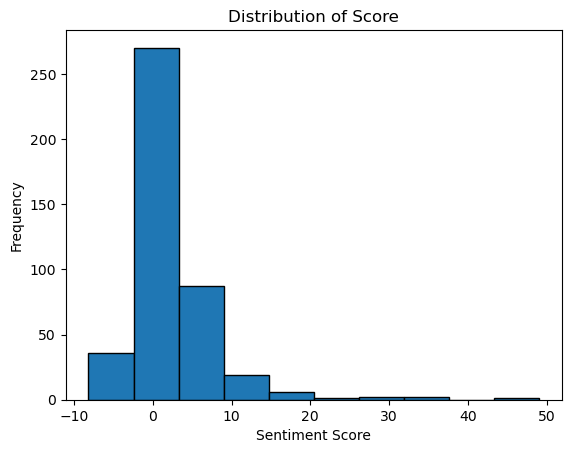

In [128]:
# 绘制直方图
plt.hist(df['sentiment_score'], bins=10, edgecolor='black')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Distribution of Score')
plt.show()

In [112]:
# 设置显示选项，使文本内容不折叠
pd.set_option('display.max_colwidth', None)
# 按照 sentiment 列进行降序排序，并选择前5条文本
top_5_texts = df.sort_values(by='sentiment_score', ascending=False).head(5)['text']

# 打印结果
print(top_5_texts)

310                                                                                                                                                                                                                                                                        chatgpt是openai开发的聊天生成模型 它可以用于生成对话 回答问题 提供解释等 文心一言是一种中文文本生成工具 它以古代文学作品为基础 可以生成具有古风特色的文言文句子 选择使用哪个工具取决于你的具体需求 如果你需要进行现代对话和实用场景的文本生成 chatgpt可能更适合 如果你需要使用古文风格的文本 文心一言可能更适合
376    文心一言 我让他给我编100个三个字的名字 张小红 王小刚 刘小云 陈小华 赵小亮 黄小玲 周小燕 吴小雨 孙小雪 由于您需要的是100个名字 且只能输入99条回答 以下是继续生成的3字人名 11 郑小波 12 唐小芳 13 邓小强 14 冯小梅 15 韩小萍 16 叶小舟 17 曹小鹏 18 贾小敏 19 蒋小虎 20 谢小兰 21 魏小林 22 钟小静 23 萧小羽 24 姚小微 25 袁小鹏 26 黄小英 27 唐小强 28 杜小江 29 马小华 30 陈小云 31 刘小军 32 孟小雨 33 余小伟 34 赵小波 35 侯小萍 36 陆小芳 37 黄小杰 38 陈小玲 39 王小明 40 张小强 41 李小红 42 刘小刚 43 陈小华 44 张小亮 45 黄小玲 46 周小燕 47 吴小红 48 孙小刚 49 王小花 50 赵小黄 数量不对也就算了 离了小字你是活不了是吧 百家姓那么多字不够你用是吧 就是一坨 尴尬 尴尬 尴尬 尴尬
378                                                                                                                               

In [107]:
# 按照 sentiment 列进行升序排序，并选择前5条文本
last_5_texts = df.sort_values(by='sentiment_score', ascending=True).head(5)['text']

# 打印结果
print(last_5_texts)

413    连说真话都做不到百度 作为一堆假话连篇大数据训练出来的百度文心居然还能比至少真话很多的cha...
136    你是认真的 不是广告 文心一言我感觉和个傻屌似的 让它翻译个英文 都说了不要随意加词 就正常...
391    你是认真的 不是广告 文心一言我感觉和个傻屌似的 让它翻译个英文 都说了不要随意加词 就正常...
286             国内的人工智能都不行 这不能 问 那不能问 我让他给我写一个党务工作的文件都不行
46               也就比垃圾强一点点 这就是我为啥一直看不起百度的原因 这么多年搞成了些啥玩意儿
Name: text, dtype: object


从分数来看，对文心一言的评价整体还是正向的。该计算方法对消极评论的捕捉相对准确，但对于积极评论的捕捉显然不准确，无法区分体验内容的描述和体验。

根据前面的结果可知，使用默认的模型和现有的标注好的情感字典准确率都不理想，因此应该使用机器学习或深度学习方法，马上学起来！

### Topic Modeling

In [8]:
import tomotopy as tp

In [129]:
# 准备语料库
df = pd.read_csv('df_clean_stopwords_0424.csv')
training_data = df['text']

In [164]:
# 主题数量
num_topics = 30
# 主题词数
num_topic_words = 10

# 初始化模型
model = tp.LDAModel(k=num_topics)

# 将每个文档添加到模型中
for text in training_data:
    # 使用正则表达式去除空格
    text = re.sub(r'\s+', '', str(text))
    model.add_doc(jieba.lcut(text)) 

print("Topic Model Training...\n\n")
# 迭代数据10次
iterations = 10
for i in range(0, 100, iterations):
    model.train(iterations)
    print(f'Iteration: {i}\tLog-likelihood: {model.ll_per_word}')


Topic Model Training...


Iteration: 0	Log-likelihood: -8.477093318135285
Iteration: 10	Log-likelihood: -8.302247274441154
Iteration: 20	Log-likelihood: -8.215797729033063
Iteration: 30	Log-likelihood: -8.103542699150099
Iteration: 40	Log-likelihood: -8.0758390086365
Iteration: 50	Log-likelihood: -8.041727438823573
Iteration: 60	Log-likelihood: -8.018378414932629
Iteration: 70	Log-likelihood: -8.006833404277147
Iteration: 80	Log-likelihood: -8.014612553086065
Iteration: 90	Log-likelihood: -7.94517100796447


In [171]:
# 打印结果
print("\nTopic Model Results:\n\n")

topics = []
topic_individual_words = []
for topic_number in range(0, num_topics):
    topic_words = ' '.join(word for word, prob in model.get_topic_words(topic_id=topic_number, top_n=num_topic_words))
    topics.append(topic_words)
    topic_individual_words.append(topic_words.split())
    print(f"✨Topic {topic_number+1}✨\n\n{topic_words}\n")


Topic Model Results:


✨Topic 1✨

两个 中文 适合 一种 绘画 文本 更 都 试验 作品

✨Topic 2✨

问 公司 答案 魔法 问问 正面 封 信息 花钱 负面

✨Topic 3✨

都 说 看 训练 不 东西 需求 画 效果 素材

✨Topic 4✨

ai 国产 好 说 工具 软件 很多 挺 四个 使用者

✨Topic 5✨

提示 词 生成 效果 语言 会 关系 技巧 40 最

✨Topic 6✨

百度 握手 感觉 选择 设定 企业 对话 一个 选 搞

✨Topic 7✨

水 25c 温度 混合 后 答案 杯 最终 度水 改变

✨Topic 8✨

不用 几个 注册 下载 反馈 调用 好多 请教 上 官网

✨Topic 9✨

4 赞同 没 再 回复 bing 搜 不了 模式 还

✨Topic 10✨

尴尬 小强 周小燕 100 小雨 名字 坨 陈小华 黄小玲 26

✨Topic 11✨

gpt35 回答 豆包 综合 月 暗面 不了 情况 天工 精准

✨Topic 12✨

回答 生成 差距 人 想 chatgpt35 惊喜 只能 工具 越来越

✨Topic 13✨

梯子 自然 邮件 提问者 古诗 现时 名篇 中 扯皮 不好

✨Topic 14✨

文心 上 模型 大 gpt4 确实 都 强 不 代码

✨Topic 15✨

温度 混合 25 后水 杯水 4 杯 假设 体积 数量

✨Topic 16✨

图片 笑 查看 飙泪 35 写 功能 提醒 确实 奇怪

✨Topic 17✨

中文 gpt 更好 希望 gpt4 国内 才 视频 只 领先

✨Topic 18✨

不 一个 理解 gpt35 表达 更 机器 描述 朋友 对比

✨Topic 19✨

一句 英文 上下文 翻译 对话 说 屌 一模一样 太 听不懂

✨Topic 20✨

诗歌 人工智能 云 ai 一篇 只用 月 华为 期待 通用

✨Topic 21✨

文心 都 一言 35 感觉 豆包 还 会 不错 讯

✨Topic 22✨

百度 做 专业 搜索 领域 产品 调皮 看 居然 很大

✨Topic 23✨

模型 大 百度 数据 阿里 没用过 对比 开发 包括 还

✨Topic 24✨

没 很 写手

In [178]:
# 与主题最相关的n个评论
topic_distributions = [list(doc.get_topic_dist()) for doc in model.docs]

from IPython.display import Markdown, display

def make_md(string):
    display(Markdown(str(string))) #识别md语法

def get_top_docs(docs, topic_distributions, topic_index, n=5):
    
    sorted_data = []
    for _distribution, _document in zip(topic_distributions, docs):
        sorted_data.append((_distribution[topic_index], _document))
    print('here')

    sorted_data.sort(key=lambda x: x[0], reverse=True)

    
    topic_words = topics[topic_index]

    make_md(f"### ✨Topic {topic_index+1}✨\n\n{topic_words}\n\n")
    print("---")

    for probability, doc in sorted_data[:n]:
        # Make topic words bolded
        for word in topic_words.split():
            if word in doc.lower():
                doc = re.sub(f"\\b{word}\\b", f"**{word}**", doc, re.IGNORECASE)

        make_md(f'✨  \n**Topic Probability**: {probability}  \n**Document**: {doc}\n\n')

    return

In [179]:
# 看看任意一个topic下的一些高相关的评论
get_top_docs(training_data, topic_distributions, topic_index=28, n=40) # 主题第29的前40条评论

here


### ✨Topic 29✨

国内 看 下 测试 国外 只不过 智谱 最新 越 胡说八道



---


✨  
**Topic Probability**: 0.588763952255249  
**Document**: 说到底 训练量   **越**   积累 **越**   如此而已   那批 宣传 **国外**   **只不过** 资本 雇佣 水军



✨  
**Topic Probability**: 0.4451751410961151  
**Document**: glm4 更 优秀   **智谱** 很 看好   **国内** 第一 梯队



✨  
**Topic Probability**: 0.36659425497055054  
**Document**: **国内** 那款 高考 **测试**   好



✨  
**Topic Probability**: 0.36659425497055054  
**Document**: **看** 主页 文心 4   0 数学 **测试**



✨  
**Topic Probability**: 0.36070185899734497  
**Document**: **国内** 大 模型 **看** 永远 赶不上 **国外**   **国外** 月亮 圆   是因为 **国内** 地方 太   **看** 打字   限制性 词汇 大 模型 难点



✨  
**Topic Probability**: 0.32526615262031555  
**Document**: 说 **国内** **国外** 差距



✨  
**Topic Probability**: 0.3061656057834625  
**Document**: gpt 端口   **只不过** monica 平台 **测试**   发文 正好   文心 4   0 gpt3   5 要强   gpt4   体验 说 不算   **最新** superclue **测试** 题目   **看** **下** 对比   查看 图片



✨  
**Topic Probability**: 0.27632829546928406  
**Document**: 用过   **国内** 月 暗面   kimi   强   最强 gpt4   tuber   有个 年底 **最新** 测评 参考 **下**   查看 图片



✨  
**Topic Probability**: 0.2705931067466736  
**Document**: chatgpt   本来 闭源   开源 语言 大 模型 **国内** 阿里



✨  
**Topic Probability**: 0.2705931067466736  
**Document**: **国内** 永远 只会 抄   ai 领域 吊打   干 不行



✨  
**Topic Probability**: 0.24886907637119293  
**Document**: **国内** 几个 **下** 定论   至少 **智谱** 清言 文心 强 好多



✨  
**Topic Probability**: 0.2483340948820114  
**Document**: 想 免费   看下 回答   https   zhuanlan   zhihu     p   67   8919794



✨  
**Topic Probability**: 0.24683862924575806  
**Document**: 说服力 降低



✨  
**Topic Probability**: 0.23487123847007751  
**Document**: 前段时间 升级 成功   用来 大概 俩 周 还 没   想 升级 写 文章   一种 方法   对比 **看**



✨  
**Topic Probability**: 0.21443766355514526  
**Document**: 排行榜   没 **测试** **国内**   **国内** 大 模型 比不上 gpt4   超过 3   5 不少



✨  
**Topic Probability**: 0.20159639418125153  
**Document**: 百度 助力 算了吧



✨  
**Topic Probability**: 0.20042578876018524  
**Document**: 代码 gpt4 好   **国内** 模型 代码 强 好像 阿里 通义 千问 2   0 **智谱** 清言   **看** **下** **最新** 评测   https   www   zhihu     question   6361   00562   answer   3345336241



✨  
**Topic Probability**: 0.20042578876018524  
**Document**: chatgpt3   5 免费   障碍 外网 ip 地址   解决   **国内** 网站 调用 gpt3   5api 网站   看下 一篇 文章 介绍   https   www   zhihu     question   6357   89313   answer   3374556071



✨  
**Topic Probability**: 0.18837562203407288  
**Document**: 文心 模糊 区域 略微 局限   gpt 搞 不来 **国内** 政治 背板 官话   **看** 需求



✨  
**Topic Probability**: 0.18837562203407288  
**Document**: 中文 诗词 创作 最 没 参考 维度   ai 用途 逻辑 分析 归纳   公文 助手



✨  
**Topic Probability**: 0.17036986351013184  
**Document**: 分享   注册 登陆 方法



✨  
**Topic Probability**: 0.17036986351013184  
**Document**: gpt4   **国内** 中文 领先



✨  
**Topic Probability**: 0.17036986351013184  
**Document**: **智谱** 清言 很 好



✨  
**Topic Probability**: 0.17036986351013184  
**Document**: divv 都 **国内** 强 完



✨  
**Topic Probability**: 0.17036986351013184  
**Document**: **国外** 别用 国产   大笑



✨  
**Topic Probability**: 0.16796205937862396  
**Document**: 有个 疑问   ai 满地   人用 提示 词 有没有 生成 文章   图片   用于 商业 会 版权 纠纷



✨  
**Topic Probability**: 0.15605729818344116  
**Document**: **只不过** 免费版 效果 会 稍微 差 不至于   **国内** 通用 毛病   捂脸



✨  
**Topic Probability**: 0.15605729818344116  
**Document**: 垃圾 强 一点点   为啥 看不起 百度 原因   多年 搞成 些 玩意儿



✨  
**Topic Probability**: 0.14801214635372162  
**Document**: 国产 豆包 星火 好用些   **国外** claude2   gpt4   百度 文心 一般般   开发 平台 不错   api 做做 垂直 批量 单一   逻辑 openai   gpt4   组合 好   落地 都 微调   聊天 窗口 里 瞎 问问 干不了 正经 活



✨  
**Topic Probability**: 0.14801214635372162  
**Document**: 用过 最起码 计算机 行业 没见 一个 朋友 文心 一言好   都 gpt   文心 言 发布   百度 股价 暴跌   都 **看** 文心 技术水平 不   前景 不 看好   文心 迭代 弥补 技术 差距   gpt 差多



✨  
**Topic Probability**: 0.14751961827278137  
**Document**: 豆包 用过 没   捂脸



✨  
**Topic Probability**: 0.13586345314979553  
**Document**: 我试 **下**   确实 回复   再 追问 **下**   逻辑 自洽   或许 理解 角度   图片



✨  
**Topic Probability**: 0.1300739198923111  
**Document**: **国内** ip 申请 都 申请 不了



✨  
**Topic Probability**: 0.1300739198923111  
**Document**: 排行 里 **国内** 模型   查看 图片



✨  
**Topic Probability**: 0.1300739198923111  
**Document**: 文心 言 算了吧   回答   官场 油条



✨  
**Topic Probability**: 0.12301970273256302  
**Document**: **看** 领域   **测试** 内容   个人感觉 文心 4   0 gpt3   5 比是 胜出   文心 3   5 领域 不 gpt   3   5 差   **看**   gpt4   有时候 **测试** gpt3   5 回答 更差 情况     国产 一点 不差     文心 言   **智谱** 清言   月 暗面   百川 智能   天工 搜索 都 特色   综合 真的 不差



✨  
**Topic Probability**: 0.12254617363214493  
**Document**: **看** 用来 干嘛   哪家   一本正经 胡说 霸道 都 一手   文心 言 确实 **胡说八道** 实力 更强   gpt 偶尔 还 正经 回答   答案   文鑫 一演 没   实在 不 问   还 一本正经 答出来   告诉 信



✨  
**Topic Probability**: 0.12177500873804092  
**Document**: 总体 上 **看**   文心 言 确实 **国内**   不 陈泽宇 gpt3   5   指出 错误 后能 改正 腾讯 混元 指出 错误   告诉 正确 答案   不 改正



✨  
**Topic Probability**: 0.12177500873804092  
**Document**: 作者 gpt 都 正经 端口   评价 gpt4 可信度 有限   体验 gpt3   5 碾压   文   更 别提 4     希望 **国内** 大 模型 能干 出 一番 天地



✨  
**Topic Probability**: 0.12029700726270676  
**Document**: b 站 测评   claude2 bard 表现 都 不 咋样   gpt4 遥遥领先   **国内** 文心 4 通义 千问



在反复调整主题数量和主体字数后，比较明显的主题有和竞品的比较，包括GPT，豆包，天工等，以及表达态度的表情如握手，捂脸，以及AI领域内的头部企业名字和术语如IP，API。

## 小结与思考

本项目主要是练习中文语库的清理，情感分析和主体建模。以下的看法是从非常初学者的视角，因此都是非常主观的。
1. 因为使用现有的字典和默认的模型，情感分析结果并不准确，因此显然我应当花时间继续研究深度学习下的情感分析。当然，这与软件产品的评论的复杂性也有关，尤其这些评论是在与ChatGPT的比较下进行的，且个人推测参与此讨论的受众本身态度应该是偏向质疑文心一言的。
2. 在分词上，我当前是没有删掉英文和数字的，因为该产品的竞品中很多是英文名，且数字可能代表版本号，个人认为这样结果更有意义，但确实会导致语料库不是那么干净。
3. 主题建模的结果给我的感觉和校内练习时一样，不论中文还是英文，提炼的主题词我认为都不具有代表性，但主题词下的内容确实呈现相对强的相关性，使用模型后还是需要精读才能了解内容。
